## Map Genes to Parcels & Communities in Schaefer
#### Cedric Huchuan Xia

#### Import necessary modules

In [1]:
import os
import subprocess
import numpy as np
import nibabel as nib
from nilearn import plotting
import pandas
import pickle

#### Set up files paths

In [2]:
# Set up the working directory
# All paths after this are relative path to the root of chead

wk_dir = '/Users/hxia/Desktop/BBL/' # this is where I have mounted chead to on my laptop. 
# Change the above to an empty string if working directly on chead 

# Set up the project directory
project_path = os.path.join(wk_dir,'data/joy/BBL/projects/prsConnectivity')

In [3]:
# Parcellation
schaefer_path = os.path.join(wk_dir,'data/joy/BBL/studies/pnc/template/Schaefer/MNI')
parcel_filename = os.path.join(schaefer_path, 'Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz')
community_filename = os.path.join(schaefer_path,'Schaefer2018_100Parcels_7Networks_order.txt')

In [4]:
# Genes
ABI_path = os.path.join(wk_dir,project_path,'ABI')
donor='10021'
gene_filename = os.path.join(ABI_path,'normalized_microarray_donor'+donor,'SampleAnnot.csv')

#### Load files

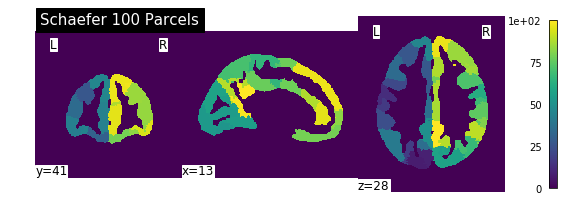

In [5]:
# Parcellation
img = nib.load(parcel_filename)
img_data = img.get_data()
plotting.plot_img(img,draw_cross=False,title='Schaefer 100 Parcels',colorbar=True)

# Community Assignment
community = pandas.read_csv(community_filename,delim_whitespace=True,header=None)

In [6]:
# Genes
gene = pandas.io.parsers.read_csv(gene_filename,delimiter=',')
gene_mni_coord = gene.iloc[:,-3:]

#### Parse the Community File

In [7]:
community_assignment ={parcel[0]: parcel[1].split('_')[2] 
                       for idx, parcel in community.iterrows()}
community_assignment[0] = 'NotAssigned'

#### Map MNI to Image Coordiantes

In [8]:
# Initiate an empty dataframe of nrow = num gene, ncol = 3 for x y z coordinates
gene_vox_coord = pandas.DataFrame(np.zeros(gene_mni_coord.shape))
gene_vox_coord.columns = ['img_x','img_y','img_z']

In [9]:
# Loop through each gene coordinate in MNI space
# and then apply FSL std2imgcoord to transform the points
# to the image voxel coordiates

for ridx, row in gene_mni_coord.iterrows():
    coord_cmd = "echo %f %f %f|std2imgcoord -img %s -std %s -vox " \
    % (row[0],row[1],row[2],parcel_filename,parcel_filename) # a shell command to apply FSL std2imgcoord
    vox_coord_str = subprocess.check_output(coord_cmd, shell = True) # get the output from the shell
    vox_coord_str_list = vox_coord_str.split()
    for cidx, coord in enumerate(vox_coord_str_list): 
        vox_coord_float = float(coord)
        gene_vox_coord.iloc[ridx][cidx] = vox_coord_float
gene_vox_coord_rd = np.round(gene_vox_coord).astype(int)

In [10]:
# Loop up parcel and community assignment for each gene
gene_parcel_assignment ={idx: img_data[tuple(gene)].astype(int)
                       for idx, gene in gene_vox_coord_rd.iterrows()}
gene_community_assignment = {idx : community_assignment[gene_parcel]
                            for idx, gene_parcel in gene_parcel_assignment.iteritems()}

In [90]:
# Concat a master loopup table of gene assignment
gene_assignment = pandas.DataFrame([gene_parcel_assignment, gene_community_assignment]).T
gene_assignment.columns = ['d{}'.format(i) for i, col in enumerate(gene_assignment, 1)]
gene_assignment.columns = ['parcel','community']
gene_assignment = pandas.concat([gene_mni_coord,gene_vox_coord,gene_assignment],axis=1)

#### Save the Variables

In [98]:
variables_filename = os.path.join(project_path,'ABI/gene_mapping','%s_100Parcels_7Network.pkl' % donor)

In [99]:
with open(variables_filename, 'w') as f:
    pickle.dump([gene_mni_coord, gene_vox_coord, gene_vox_coord_rd,
                 gene_parcel_assignment,gene_community_assignment,gene_assignment],f)

In [100]:
#write gene_assignment to a csv
csv_filename = os.path.join(project_path,'ABI/gene_mapping','%s_100Parcels_7Network.csv' % donor)
gene_assignment.to_csv(path_or_buf=csv_filename)

#### A preview of the outputs

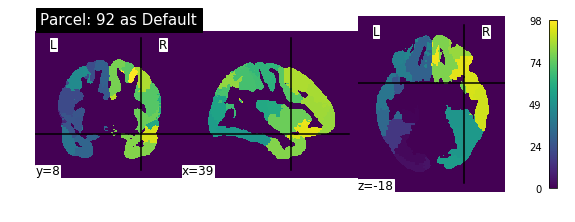

In [74]:
ex_gene = 40
plotting.plot_img(img,draw_cross=True,cut_coords = tuple(gene_mni_coord.ix[ex_gene]),\
                  title='Parcel: ' + gene_parcel_assignment.values()[ex_gene].astype(str) + \
                  ' as '+ gene_community_assignment.values()[ex_gene], colorbar=True)

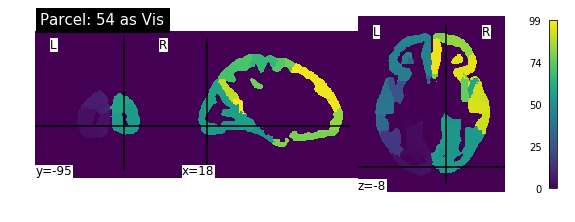

In [82]:
ex_gene = 354
plotting.plot_img(img,draw_cross=True,cut_coords = tuple(gene_mni_coord.ix[ex_gene]),\
                  title='Parcel: ' + gene_parcel_assignment.values()[ex_gene].astype(str) + \
                  ' as '+ gene_community_assignment.values()[ex_gene], colorbar=True)

In [101]:
gene_assignment.head(10)

,mni_x,mni_y,mni_z,img_x,img_y,img_z,parcel,community
0,-29.2,5.8,-2.6,119.2,131.8,69.4,0,NotAssigned
1,-10.1,5.9,-8.4,100.1,131.9,63.6,0,NotAssigned
2,8.9,8.5,-7.4,81.1,134.5,64.6,0,NotAssigned
3,7.9,0.8,-6.7,82.1,126.8,65.3,0,NotAssigned
4,16.9,0.9,-9.1,73.1,126.9,62.9,0,NotAssigned
5,37.0,-0.5,4.1,53.0,125.5,76.1,76,SalVentAttn
6,13.4,2.2,0.2,76.6,128.2,72.2,0,NotAssigned
7,24.8,1.7,-22.1,65.2,127.7,49.9,80,Limbic
8,19.2,0.7,-14.9,70.8,126.7,57.1,0,NotAssigned
9,18.1,1.6,-22.1,71.9,127.6,49.9,0,NotAssigned
